# Ames Iowa Housing Data Import and Data Cleaning
### In this process some home-spun modules are used and stored in `data_cleaning.py` and `data_viz.py`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_cleaning
import data_viz

%matplotlib inline

In [2]:
test = False
df = data_cleaning.read_it(test=test)

(2051, 81)


In [3]:
data_cleaning.snake_df(df)

In [4]:
null_nums = [df.select_dtypes(np.number).columns[i] 
             for i in range(len(df.select_dtypes(np.number).columns)) 
             if df.select_dtypes(np.number).isnull().mean()[i] > 0]

These are the numeric columns with `null` values:

`'lot_frontage',
 'mas_vnr_area',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'garage_yr_blt',
 'garage_cars',
 'garage_area'`

I worked on the garage data first, setting years built and appropriate other items.

In [5]:
df[(df['garage_yr_blt'].isnull()) & (df['garage_type'] != 'na') ][['year_built','year_remod/add']]
df.loc[(df['garage_yr_blt'].isnull()) & (df['garage_type'] != 'na'),'garage_yr_blt'] = 1923

### Many values were filled with `np.nan` and needed to be filled. Consulting the [Data Dictionary](https://www.kaggle.com/c/dsi-us-9-project-2-regression-challenge/data) I saw that they should be filled be 0 if they are numerical data, indicating a lack of that feature.

In [6]:
#fill some NA's that need to be there
na_dict = {'lot_frontage' : 0,
           'mas_vnr_area': 0,
           'garage_area':0,
           'garage_cars': df[df['garage_cars'] == df['garage_cars'].value_counts().index[0]]['garage_area'].mean(),
           'garage_yr_blt': 0,
           'bsmt_full_bath': 0,
           'bsmt_half_bath': 0,
           'bsmtfin_sf_1': 0,
           'bsmtfin_sf_2': 0,
           'bsmt_unf_sf': 0,
           'total_bsmt_sf': 0,
     }
df.fillna(na_dict, inplace=True)

In [7]:
null_nums = [df.select_dtypes(np.number).columns[i] 
             for i in range(len(df.select_dtypes(np.number).columns)) 
             if df.select_dtypes(np.number).isnull().mean()[i] > 0]

### Repeat the process for categorical data.

In [8]:
# now let's check out categorical data!
null_objs = [df.select_dtypes(object).columns[i] 
             for i in range(len(df.select_dtypes(object).columns)) 
             if df.select_dtypes(object).isnull().mean()[i] > 0]

These are the non-numeric columns with `null` values:

`'alley',
 'mas_vnr_type',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_type_2',
 'fireplace_qu',
 'garage_type',
 'garage_finish',
 'garage_qual',
 'garage_cond',
 'pool_qc',
 'fence',
 'misc_feature'`

### In this section I check to see if these `null` values correspond with features that do not exist in the house or are missing data.

full evaluations were done but only the `.head()` output is included here.

In [9]:
df[df['mas_vnr_type'].isnull()][['mas_vnr_area']].head()

,mas_vnr_area
22,0.0
41,0.0
86,0.0
212,0.0
276,0.0


In [10]:
bsmt = ['bsmt_qual',
        'bsmt_cond',
        'bsmt_exposure',
        'bsmtfin_type_1',
        'bsmtfin_sf_1',
        'bsmtfin_type_2'
       ]

df[df['bsmt_qual'].isnull()][bsmt].head()

,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2
12,NaN,NaN,NaN,NaN,0.0,NaN
93,NaN,NaN,NaN,NaN,0.0,NaN
114,NaN,NaN,NaN,NaN,0.0,NaN
146,NaN,NaN,NaN,NaN,0.0,NaN
183,NaN,NaN,NaN,NaN,0.0,NaN


In [11]:
df[df['fireplace_qu'].isnull()][['fireplaces']].head()

,fireplaces
0,0
2,0
3,0
4,0
6,0


In [12]:
df[df['garage_finish'].isnull()][['garage_type']].head()

,garage_type
28,NaN
53,NaN
65,NaN
79,NaN
101,NaN


### By looking at the data dictionary, the other `null` values should be set to `'na'` to indicate the lack of a feature.

In [13]:
#fill some NA's that need to be there
na_dict = {'bsmt_qual': 'na',
           'bsmt_cond': 'na',
           'bsmt_exposure': 'na',
           'bsmtfin_type_1': 'na',
           'bsmtfin_type_2': 'na',
           'mas_vnr_type': 'none',
           'fireplace_qu': 'na',
           'garage_finish': 'na',
           'garage_qual': 'na',
           'garage_cond': 'na',
           'garage_type': 'na',
           'alley': 'na',
           'pool_qc': 'na',
           'fence': 'na',
           'misc_feature': 'na',
           'electrical': df['electrical'].value_counts().index[0],
          }
df.fillna(na_dict, inplace=True)

### Ordinal values should be ordered based on the grading quality.
These are established based on the Data Dictionary. Excellent was given 5 and NA 0. 

In [14]:
ordinal_dict = {
    'ex':5,
    'gd':4,
    'ta':3,
    'fa':2,
    'po':1,
    'na':0,
}

ordinal_columns = [column
 for column
 in df.columns.values 
 if "_qu" in column or "_cond" in column or "_qc" in column
]
not_ordinal = ['overall_qual','overall_cond','low_qual_fin_sf']
ordinal_columns = list(set(ordinal_columns) - set(not_ordinal))
df[ordinal_columns] = df[ordinal_columns].replace(ordinal_dict)
%store ordinal_columns #for later

Stored 'ordinal_columns' (list)


### Convert `ms_subclass` to Categorical
This variable has numeric codes that correspond with building types. I mapped the codes to the building types and then ran it through snake_df at the end to clean it up.

In [15]:
ms_subclass_dict = {20: "1-STORY 1946 NEWER ALL STYLES",
30: "1-STORY 1945 OLDER",
40: "1-STORY FINISHED ATTIC ALL AGES",
45: "1-1/2 STORY UNFINISHED ALL AGES",
50: "1-1/2 STORY FINISHED ALL AGES",
60: "2-STORY 1946 NEWER",
70: "2-STORY 1945 OLDER",
75: "2-1/2 STORY ALL AGES",
80: "SPLIT OR MULTI-LEVEL",
85: "SPLIT FOYER",
90: "DUPLEX - ALL STYLES AND AGES",
120: "1-STORY PUD (Planned Unit Development) - 1946 NEWER",
150: "1-1/2 STORY PUD - ALL AGES",
160: "2-STORY PUD - 1946 NEWER",
180: "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER",
190: "2 FAMILY CONVERSION - ALL STYLES AND AGES"
                   }
df['ms_subclass'] = df['ms_subclass'].replace(ms_subclass_dict)
data_cleaning.snake_df(df)

# Save out the test dataset here.

In [16]:
data_cleaning.save_it(df, test)

CSV saved to datasets/train_cleaned.csv


# Outlier Detection
At this point it felt pertinent to start looking not just at the structure of the data but the content as well, using some visualizations to detect outliers and straighten the data up.

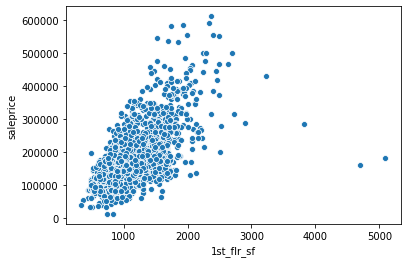

In [17]:
sns.scatterplot(data=df,
               x = '1st_flr_sf',
                y = 'saleprice'
               )

In [18]:
df.loc[df['1st_flr_sf'] > 3500,:]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
616,1498,908154080,1-story 1946 newer all styles,rl,123.0,47007,pave,na,ir1,lvl,...,0,0,0,na,na,0,7,2008,wd,284700
960,1499,908154235,2-story 1946 newer,rl,313.0,63887,pave,na,ir3,bnk,...,0,480,4,na,na,0,1,2008,new,160000
1885,2181,908154195,1-story 1946 newer all styles,rl,128.0,39290,pave,na,ir1,bnk,...,0,0,0,na,elev,17000,10,2007,new,183850


In [19]:
drop_sales_sf = df.loc[df['1st_flr_sf'] > 3000,:].index.values
df = df.drop(axis=0, index=drop_sales_sf)

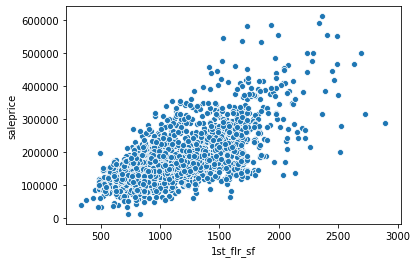

In [20]:
sns.scatterplot(data=df,
               x = '1st_flr_sf',
                y = 'saleprice'
               );

In [21]:
scatter_these = ['lot_frontage','lot_area','mas_vnr_area','wood_deck_sf','open_porch_sf']


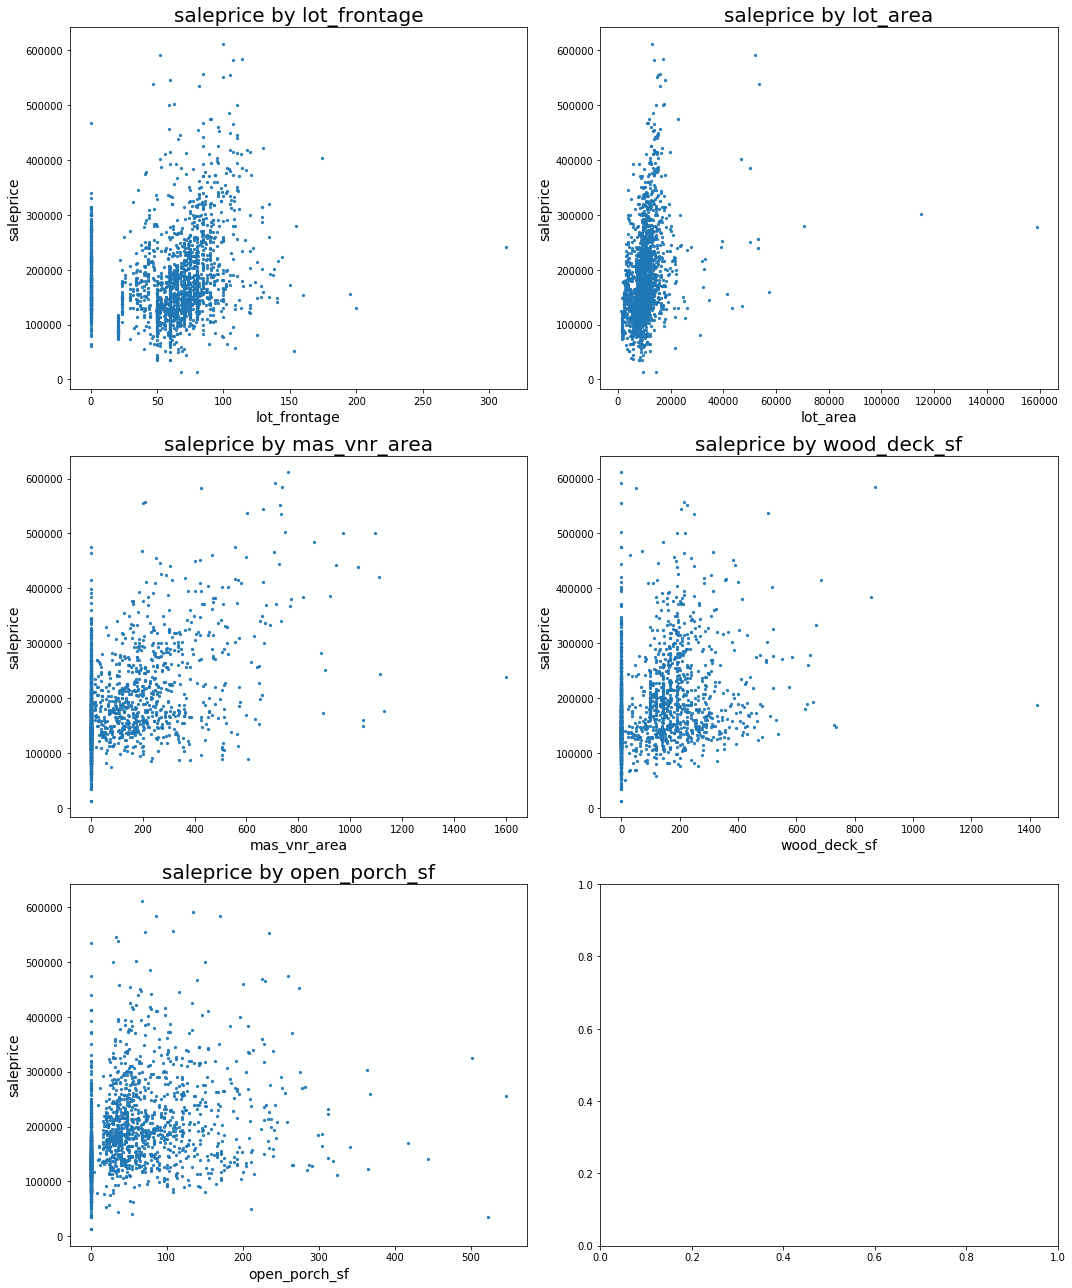

In [22]:
data_viz.subplot_scatterz(
    dataframe = df,
    predict_variables = scatter_these,
    target_variable = 'saleprice',
)

In [23]:
drop_mask = (df['lot_frontage'] > 180) | (df['lot_area'] > 70000) | (df['mas_vnr_area'] > 1500) | (df['wood_deck_sf'] > 1400) | (df['open_porch_sf'] > 400)
drop = df.loc[drop_mask,:].index.values
df = df.drop(axis = 0, index=drop)

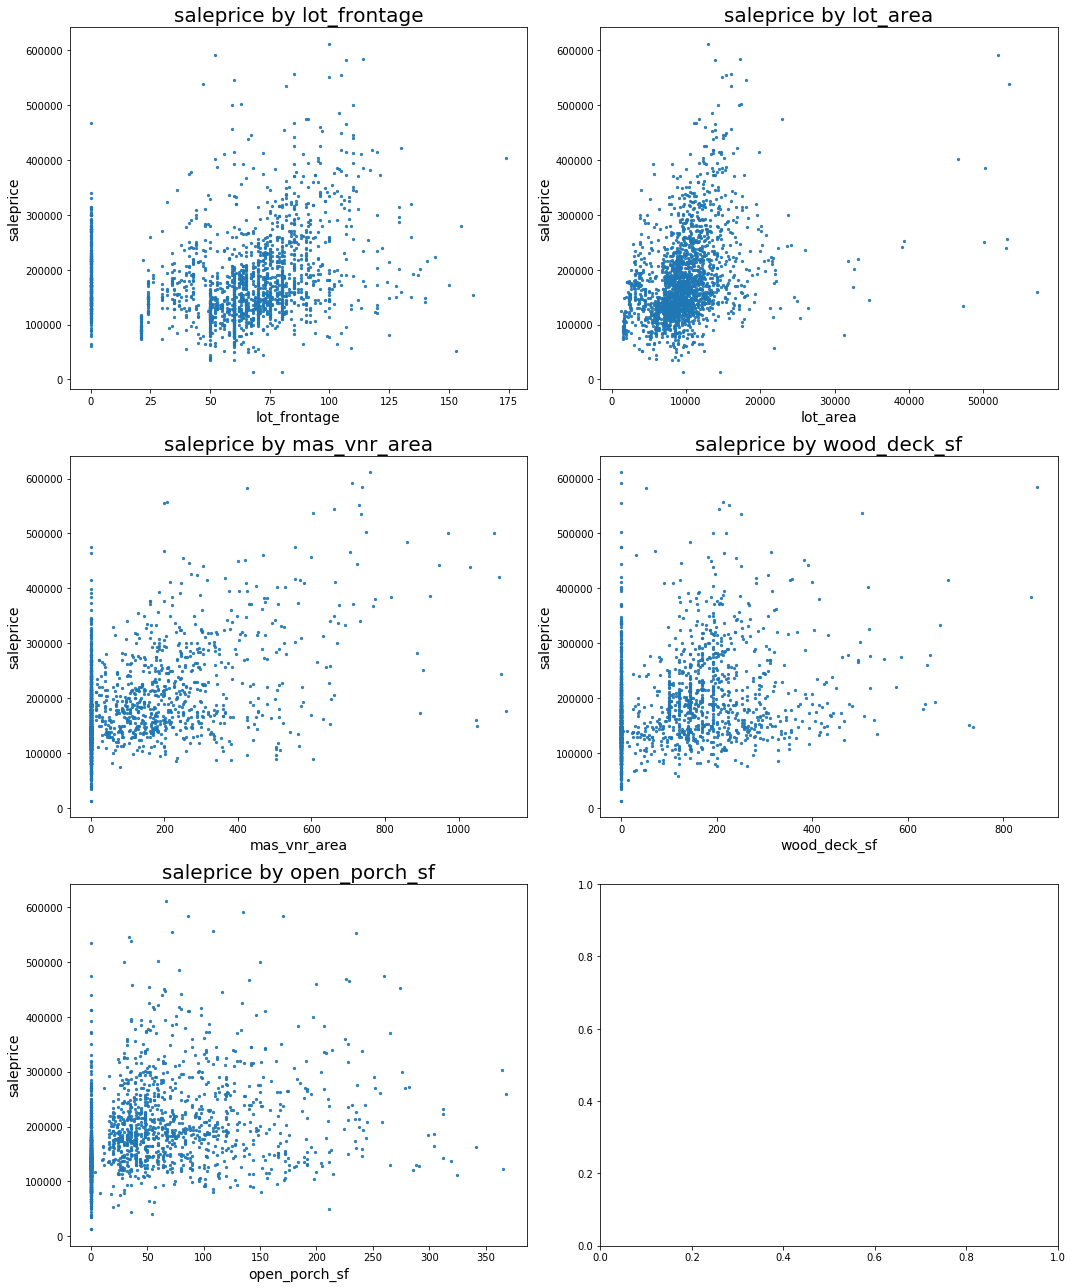

In [24]:
data_viz.subplot_scatterz(
    dataframe = df,
    predict_variables = scatter_these,
    target_variable = 'saleprice',
)

# Save your fresh and clean dataset and store the variable to share across notebooks

In [25]:
data_cleaning.save_it(df, test)

CSV saved to datasets/train_cleaned.csv


## On to [Exploratory Data Analysis & Initial Modeling](2_EDA_and_feature_engineering.ipynb)